# ECE 590, Fall 2019 
## Problem Set 5
 

## Full name: Bingying Liu


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Download and prepare the Fashion MNIST data set 
batch_size = 500
train_dataset = dsets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataset = dsets.FashionMNIST(root='./data', train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
"""
The data features can be extracted as train_dataset/test_dataset.data
The labels can be extracted as train_dataset/test_dataset.targets 
"""

'\nThe data features can be extracted as train_dataset/test_dataset.data\nThe labels can be extracted as train_dataset/test_dataset.targets \n'

In [3]:
class ConvNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1, padding=0, bias=True) # Choose 6 filters
        self.fc1   = nn.Linear(in_features=6*12*12, out_features=out_channels)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [7]:
losses = []
def train(model, train_loader, criterion, optimizer, epoch):
    train_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if batch_idx % (len(train_loader)//2) == 0:
            losses.append(train_loss/(batch_idx+1))
            print('Train({})[{:.0f}%]: Loss: {:.4f}'.format(
                epoch, 100. * batch_idx / len(train_loader), train_loss/(batch_idx+1)))

accuracies = []
def test(model, test_loader, criterion, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = (test_loss*batch_size)/len(test_loader.dataset)
    accuracies.append(correct / len(test_loader.dataset))
    print('Test({}): Loss: {:.4f}, Accuracy: {:.4f}%'.format(
        epoch, test_loss, 100. * correct / len(test_loader.dataset)))

In [8]:
def make_optimizer(optimizer_name, model, **kwargs):
    if optimizer_name=='Adam':
        optimizer = optim.Adam(model.parameters(),betas=(0.9, 0.999), eps=1e-08, lr=kwargs['lr'])
    else:
        raise ValueError('Not valid optimizer name')
    return optimizer
    
def make_scheduler(scheduler_name, optimizer, **kwargs):
    if scheduler_name=='MultiStepLR':
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones=kwargs['milestones'],gamma=kwargs['factor'])
    else:
        raise ValueError('Not valid scheduler name')
    return scheduler

In [9]:
seed = 1
optimizer_name = 'Adam'
scheduler_name = 'MultiStepLR'
num_epochs = 20
lr = 0.01
torch.manual_seed(1)
in_channels = 1
out_channels = 10
model = ConvNet(in_channels, out_channels)
criterion = nn.CrossEntropyLoss()
optimizer = make_optimizer(optimizer_name, model, lr=lr)
scheduler = make_scheduler(scheduler_name, optimizer, milestones=[5], factor=0.1)
for epoch in range(1, num_epochs + 1):
    train(model, train_loader, criterion, optimizer, epoch)
    test(model, test_loader, criterion, epoch)
    scheduler.step()
    if epoch % 50 == 0:
        print('Optimizer Learning rate: {0:.4f}'.format(optimizer.param_groups[0]['lr']))

Train(1)[0%]: Loss: 2.3729
Train(1)[50%]: Loss: 0.7492
Test(1): Loss: 0.4512, Accuracy: 84.1900%
Train(2)[0%]: Loss: 0.4177
Train(2)[50%]: Loss: 0.4099
Test(2): Loss: 0.4016, Accuracy: 86.2400%
Train(3)[0%]: Loss: 0.3471
Train(3)[50%]: Loss: 0.3592
Test(3): Loss: 0.3689, Accuracy: 87.2400%
Train(4)[0%]: Loss: 0.3359
Train(4)[50%]: Loss: 0.3283
Test(4): Loss: 0.3398, Accuracy: 87.9200%
Train(5)[0%]: Loss: 0.3381
Train(5)[50%]: Loss: 0.3086
Test(5): Loss: 0.3338, Accuracy: 88.1400%
Train(6)[0%]: Loss: 0.2738
Train(6)[50%]: Loss: 0.2818
Test(6): Loss: 0.3210, Accuracy: 88.9300%
Train(7)[0%]: Loss: 0.2451
Train(7)[50%]: Loss: 0.2784
Test(7): Loss: 0.3194, Accuracy: 89.0100%
Train(8)[0%]: Loss: 0.2963
Train(8)[50%]: Loss: 0.2782
Test(8): Loss: 0.3186, Accuracy: 89.0000%
Train(9)[0%]: Loss: 0.2425
Train(9)[50%]: Loss: 0.2760
Test(9): Loss: 0.3175, Accuracy: 88.8900%
Train(10)[0%]: Loss: 0.3073
Train(10)[50%]: Loss: 0.2767
Test(10): Loss: 0.3175, Accuracy: 88.7400%
Train(11)[0%]: Loss: 0.2369

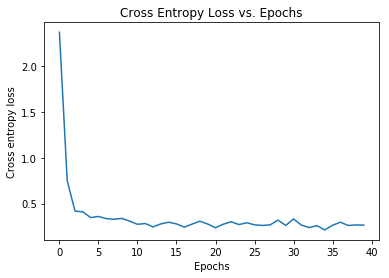

In [10]:
import matplotlib.pyplot as plt
plt.title("Cross Entropy Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Cross entropy loss")
plt.plot(range(len(losses)),losses)
plt.show()

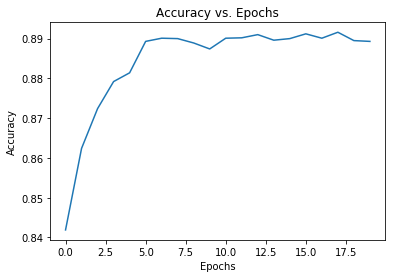

In [11]:
plt.plot(range(len(accuracies)),accuracies)
plt.title("Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()